# Processing big model output data

This notebook serves as a stack of examples of how to make you of various `python` based data processing libraries to process *large* data from high resolution model output. 

In this notebook we are going to process data from the *Dyamond Winter* project as an example. The data is available on mistral hence the notebook should be applied in a *mistral* computing environment to access the data.

### Import Libraries:

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from subprocess import run, PIPE

from cartopy import crs as ccrs # Cartography library
import dask # Distributed data libary
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from hurry.filesize import size as filesize # Get human readable file sizes
from matplotlib import pyplot as plt # Standard Plotting library
from metpy import calc as metcalc # Calculate atmospheric variables
from metpy.units import units as metunits # Easy to use meteorological units
import numpy as np # Standard array library
import pandas as pd # Libary to work with labeled data frames and time series
import seaborn as sns # Makes plots more beautiful
import xarray as xr # Libary to work with labeled n-dimensional data and dask

### 2.0 Setup a distributed computing cluster where we can process the data:

The data we are going to process is in the order of TB. On a single machine using a single core this can not only be slow but also the fields we are trying to process won't fit into a single computers memory. Therefore we're setting up a distributed cluster using the `dask_jobqueue` library. Specifically we will involve the *Slurm* workload manager to to that. More information on the `dask_jobqueue` library can be found here: https://jobqueue.dask.org/en/latest/ . 

To create the slum cluster we need some information, like the account that is going to be charged and the partition that is going to be used. In this example we are going to use the GPU partition but any other partition can be involved:

In [2]:
# Set some user specific variables
account_name = 'mh0731' # Account that is going to be 'charged' fore the computation
partition = 'prepost' # Name of the partition we want to use
job_name = 'dyamondProc' # Job name that is submitted via sbatch
memory = "200GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 42 # Max number of cores per that are reserved - also partition dependend
walltime = '12:00:00' # Walltime - also partition dependen

In [3]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_scratch_dir = TemporaryDirectory(dir=scratch_dir, prefix='DyamondProc')
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=partition,
                       local_directory=dask_scratch_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_scratch_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_scratch_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

So far nothing has happened, lets order 10 nodes which will give us 420 cores and 2 TB distributed memory to work on:

In [4]:
cluster.scale(10)
cluster

Now we have submitted two jobs that establish the distributed computing resources. After some queuing time, depending on how busy the computer is. The resources will be available. This can be seen when the above interfaces changes from 

**Workers**   0/10

to

**Workers** 10

We can also check the status by calling the `squeue` command from bash:

In [5]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          21778712   prepost dyamondP  m300765  R       2:29      1 m11543
          21778713   prepost dyamondP  m300765  R       2:29      1 m11555
          21778714   prepost dyamondP  m300765  R       2:29      1 m11556
          21778715   prepost dyamondP  m300765  R       2:29      1 m11557
          21778716   prepost dyamondP  m300765  R       2:29      1 m11558
          21778717   prepost dyamondP  m300765  R       2:29      1 m11559
          21778718   prepost dyamondP  m300765  R       2:29      1 m11513
          21778719   prepost dyamondP  m300765  R       2:29      1 m11514
          21778711   prepost dyamondP  m300765  R       2:57      1 m11549
          21778710   prepost dyamondP  m300765  R       2:59      1 m11548


Now that the computing resources are made available we have to connect a client to it. This client servers as an instance between the commands we are going to use and the cluster. Let's create the client. This can be done by calling the `Client` instance with the cluster we have just created. This will tell dask the distributed library do to all calculations on the cluster.

In [6]:
dask_client = Client(cluster)

If not workers are available yet not computation will be done. Once the workers become available computation can be executed on the available worker only. So in general it is a good idea to wait until as much as possible workers are available and yet more computing resources is can be utilized.

In [7]:
# Blocking call to wait for at least 10 workers before continuing; 
# This might take a while so grab a coffee or tea
dask_client.wait_for_workers(10)
dask_client

Client Scheduler: tcp://10.50.32.30:41088 Dashboard: http://10.50.32.30:8787/status,Cluster Workers: 10 Cores: 420 Memory: 2.15 TB


### 3.0 Read 2D input data

Let's define the paths and the variables we are going to read. In this example we want to compare two datasets that is:

* dpp0015 : Coupled dyamond run with standard parameter configuration
* dpp0017 : Coupled dyamond run with increased ocean albedo and increased inversion parameter Cₙ

In this example we will make use of six hourly data which is store in `<exp>_2d_atm_ml_<timestep>.nc` file patterns.

In [8]:
# Define paths here
paths = {'dpp0015' : Path('/work/mh0287/k203123/GIT/icon-aes-dyw/experiments') / 'dpp0015',
         'dpp0018' : Path('/work/mh0287/k203123/GIT/icon-aes-dyw_albW/experiments') / 'dpp0018'}
glob_pattern_2d = 'atm_2d_ml'
dpp_runs = list(paths.keys())

The runs can be read with the `open_mfdataset` from `xarray`. This methods takes quite a number of arguments. We will try opening all the `<exp>_2d_atm_ml_<timestep>.nc` files and merging them into one big dataset. It should be noted thet `open_mfdataset` doesn't read any data until told. What it does, is just fetching meta data and creating a view to the data.

In [9]:
datasets = {}
for exp in dpp_runs:
    print(f'Reading data from {exp}', end='\r')
    datasets[exp] = xr.open_mfdataset(
        str(paths[exp] / f'{exp}*{glob_pattern_2d}*.nc'), 
        combine='by_coords',
        parallel=True,
        chunks={'time': 1}) # The chunking will get important when we read 3d data.
print(f'Done {50*" "}')

Done                                                   


In [10]:
# dpp0017 has only data until 2st of February so we take a subset of both datasets:
for exp in dpp_runs:
    datasets[exp] = datasets[exp].sel({'time': slice('2020-01-21T00:00:00', '2020-02-01T18:00:00')})

In [11]:
datasets['dpp0015'].time

<xarray.DataArray 'time' (time: 48)>
array(['2020-01-21T00:00:00.000000000', '2020-01-21T06:00:00.000000000',
       '2020-01-21T12:00:00.000000000', '2020-01-21T18:00:00.000000000',
       '2020-01-22T00:00:00.000000000', '2020-01-22T06:00:00.000000000',
       '2020-01-22T12:00:00.000000000', '2020-01-22T18:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-23T06:00:00.000000000',
       '2020-01-23T12:00:00.000000000', '2020-01-23T18:00:00.000000000',
       '2020-01-24T00:00:00.000000000', '2020-01-24T06:00:00.000000000',
       '2020-01-24T12:00:00.000000000', '2020-01-24T18:00:00.000000000',
       '2020-01-25T00:00:00.000000000', '2020-01-25T06:00:00.000000000',
       '2020-01-25T12:00:00.000000000', '2020-01-25T18:00:00.000000000',
       '2020-01-26T00:00:00.000000000', '2020-01-26T06:00:00.000000000',
       '2020-01-26T12:00:00.000000000', '2020-01-26T18:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-27T06:00:00.000000000',
       '2020-01-27T12:00:00.000000000', '2020-01-27T18:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-28T06:00:00.000000000',
       '2020-01-28T12:00:00.000000000', '2020-01-28T18:00:00.000000000',
       '2020-01-29T00:00:00.000000000', '2020-01-29T06:00:00.000000000',
       '2020-01-29T12:00:00.000000000', '2020-01-29T18:00:00.000000000',
       '2020-01-30T00:00:00.000000000', '2020-01-30T06:00:00.000000000',
       '2020-01-30T12:00:00.000000000', '2020-01-30T18:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-01-31T06:00:00.000000000',
       '2020-01-31T12:00:00.000000000', '2020-01-31T18:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-01T06:00:00.000000000',
       '2020-02-01T12:00:00.000000000', '2020-02-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 ... 2020-02-01T18:00:00
Attributes:
    standard_name:  time
    axis:           T

In [12]:
datasets['dpp0018'].time # This data is daily data only

<xarray.DataArray 'time' (time: 12)>
array(['2020-01-21T00:00:00.000000000', '2020-01-22T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-25T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-28T00:00:00.000000000',
       '2020-01-29T00:00:00.000000000', '2020-01-30T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2020-02-01
Attributes:
    standard_name:  time
    axis:           T

In [13]:
# Merge both datasets in one dataet together to make it easier to work with them:
datasets = xr.concat(list(datasets.values()), dim='exp').assign_coords({'exp': list(datasets.keys())})
datasets

<xarray.Dataset>
Dimensions:  (exp: 2, ncells: 20971520, time: 48)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 ... 2020-02-01T18:00:00
  * exp      (exp) <U7 'dpp0015' 'dpp0018'
Dimensions without coordinates: ncells
Data variables:
    ps       (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    psl      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsdt     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsut     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsutcs   (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlut     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlutcs   (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsds     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsdscs   (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlds     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rldscs   (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsus     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsuscs   (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlus     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    ts       (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    sic      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    sit      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    clt      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    prlr     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    prls     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    pr       (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    prw      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    cllvi    (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    clivi    (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qgvi     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qrvi     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qsvi     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    hfls     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    hfss     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    evspsbl  (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    tauu     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    tauv     (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    sfcwind  (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    uas      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    vas      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    tas      (exp, time, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:        

In [14]:
global_attrs = datasets.attrs
var_attrs = {varn: datasets[varn].attrs for varn in datasets.data_vars}

In [15]:
def set_attrs(dataset):
    '''Set attributes to a dataset that might have lost its attributes.'''
    dataset.attrs = global_attrs
    first_attr = list(var_attrs.values())[0]
    for varn in dataset.data_vars:
        try:
            dataset[varn].attrs = var_attrs[varn]
        except KeyError:
            dataset[varn].attrs = first_attr
    return dataset

At this stage no data - except for meta data - has been read. Since meta data is present we can inspect the dataset a little further:

In [16]:
datasets.sel({'exp': 'dpp0015'})['ts']

<xarray.DataArray 'ts' (time: 48, ncells: 20971520)>
dask.array<getitem, shape=(48, 20971520), dtype=float32, chunksize=(1, 20971520), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 ... 2020-02-01T18:00:00
    exp      <U7 'dpp0015'
Dimensions without coordinates: ncells
Attributes:
    standard_name:                surface_temperature
    long_name:                    surface temperature
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [17]:
datasets.sel({'exp': 'dpp0015'})['ts'].data

dask.array<getitem, shape=(48, 20971520), dtype=float32, chunksize=(1, 20971520), chunktype=numpy.ndarray>

The data attribute returns either data array or if the data hasn't been written yet a representation of what the *will* look like. It is also called a *future*, a very important concept for distributed computing. In our case the representation of the data is a *dask* array. *Dask* is a library that can split up the data into chunks and evenly spreads the data chunks across different cpu's and computers. In our example we can see that the *surface* temperature dataset is split up into 44 chunks. Reading the array would take 935 tasks the total dataset would take 3.69 GB of memory. We can also ask xarray how much memory the whole dataset would consume:

In [18]:
filesize(datasets.nbytes) # Use the filesize module to make the output more readable

'270G'

This means that the total dataset (both experiments) would need 270 GB of memory. Way to much for a local computer but we do have 1.5 TB of distributed memory. Although this data would comfortably fit there we can reduce its size a little further by throwing out variables we don't need and creating daily averages (the data is 6 hourly).

In [19]:
# Reduce the data a little further, get only interesting variables
data_vars = ['clivi', 'cllvi', 'clt', 'hfls', 'hfss', 'pr', 'prw', 'ps', 'qgvi', 'qrvi',
             'qsvi', 'rlds', 'rlus', 'rlut', 'rsds', 'rsdscs', 'rsdt', 'rsus', 'rsuscs',
             'rsut', 'rsutcs', 'tas', 'ts', 'uas', 'vas']
datasets = datasets[data_vars]
# Create daily average
datasets = datasets.resample({'time': '1D'}).mean()
# We lost attributes set the saved once now
datasets.attrs = global_attrs
for varn in datasets.data_vars:
    datasets[varn].attrs = var_attrs[varn]
datasets

<xarray.Dataset>
Dimensions:  (exp: 2, ncells: 20971520, time: 12)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2020-02-01
  * exp      (exp) <U7 'dpp0015' 'dpp0018'
Dimensions without coordinates: ncells
Data variables:
    clivi    (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    cllvi    (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    clt      (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    hfls     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    hfss     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    pr       (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    prw      (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    ps       (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qgvi     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qrvi     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    qsvi     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlds     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlus     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rlut     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsds     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsdscs   (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsdt     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsus     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsuscs   (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsut     (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    rsutcs   (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    tas      (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    ts       (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    uas      (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
    vas      (time, exp, ncells) float32 dask.array<chunksize=(1, 1, 20971520), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  15
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9
    title:                ICON simulation
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@6b5726d38970a4...
    history:              /work/mh0287/k203123/GIT/icon-aes-dyw/bin/icon at 2...
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on m11338 (Linux 2.6.32-...

In [20]:
datasets['tas']

<xarray.DataArray 'tas' (time: 12, exp: 2, ncells: 20971520)>
dask.array<concatenate, shape=(12, 2, 20971520), dtype=float32, chunksize=(1, 1, 20971520), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2020-02-01
  * exp      (exp) <U7 'dpp0015' 'dpp0018'
Dimensions without coordinates: ncells
Attributes:
    standard_name:                tas
    long_name:                    temperature in 2m
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [21]:
filesize(datasets.nbytes)

'46G'

This means we have significantly reduced the size that will by held in memory. But beware, this is the size that will be occupied in memory once the data has been read. The reading, chunking and averaging process will take much more memory. Although dask tries to optimize the memory consumption as much as possible.

So far no data has been read. We can trigger reading the data by using the `persist` method. Persist will start pushing the data to the distributed memory. There the `netcdf-files` will be read the the data will be copied into memory and the averaging will be done. If no distributed memory is available persist uses the local memory. To use the local memory in the first place one can use the `compute` method. Please also refer to https://distributed.readthedocs.io/en/latest/manage-computation.html#dask-collections-to-futures for more information.

But before we trigger computations on the cluster, we can create some additional datasets. That is net top of the atmosphere radiation budget and net surface energy:

In [22]:
datasets['net_sw_toa'] = datasets['rsdt'] - datasets['rsut']
datasets['net_lw_toa'] = -datasets['rlut']
datasets['net_sw_surf'] = datasets['rsds'] - datasets['rsus']
datasets['net_lw_surf'] = datasets['rlds'] - datasets['rlus']
datasets['net_toa'] = datasets['net_sw_toa'] + datasets['net_lw_toa']
datasets['net_surf'] = datasets['net_sw_surf'] + datasets['net_lw_surf']
datasets['net_surf_energy'] = datasets['net_surf'] + datasets['hfss'] + datasets['hfls']

In [23]:
# Push the data to the cluster and trigger all computations there
datasets = datasets.persist()

This will trigger the computation in the background, we don't have to wait but can keep on analyzing the data. The `progress` class from dask provides the opportunity to get a progress bar that runs in the background to inform the user about the status.

In [24]:
# Let's inspect the progress
progress(datasets, notebook=True)

VBox()

We can see the tasks that are worked on in the background on the cluster. We can continue working with the data. The paradigm is that all calculations are collected and *not* executed until we explicitly instruct xarray / dask to trigger computations. 

### 3.1 Sub setting the data

Suppose we wanted to work on say tropical areas only we would have to find a way of accessing the right grid triangles and omitting those once outside the tropics. Sub setting the data would be easy if the would be on a lat-lon grid. Then could simply do something like this:

```python
data_tropics = datasets.sel({'lat': slice(-30, 30)})
```
Since we are working with unstructured grids things are a little more complex but can be done. Essentially we have two options:

* Creating an index and getting the data via the index.
* Masking the data that we don't need.

Both options involve more information on the grid. Let's read a land-see mask file:

In [25]:
grid_path = Path('/work/mh0731/m300765/graupel_tuning')
lsm_file = grid_path / 'r02b09_land_frac.nc'
lsm = xr.open_dataset(lsm_file, chunks={'cell': -1}).load() # Load the file into local memory first
lons, lats = np.rad2deg(lsm.clon), np.rad2deg(lsm.clat) #Read lon, lat vector

The `.load` method loads the data into *local* memory. We can see the difference of the data attribute once the data is in the local memory instead of distributed memory or not loaded at all yet:

In [26]:
lsm['sea'].data

array([-0., -0., -0., ...,  1.,  1.,  1.])

In [27]:
# Create sea and land masks and push the data to the distributed memory
s_mask = np.full(lsm['sea'].shape, np.nan) # Creat nan arrays
l_mask = np.full(lsm['sea'].shape, np.nan)
l_mask[lsm['land'].data == 1] = 1
s_mask[lsm['sea'].data == 1] = 1
s_mask

array([nan, nan, nan, ...,  1.,  1.,  1.])

In [28]:
# Create a dask array from the sea/land_mask and push it to the cluster
s_mask = dask.persist(dask.array.from_array(s_mask, chunks=-1))[0] # Push the data to the cluster
l_mask = dask.persist(dask.array.from_array(l_mask, chunks=-1))[0]

In [29]:
s_mask

dask.array<array, shape=(20971520,), dtype=float64, chunksize=(20971520,), chunktype=numpy.ndarray>

In [30]:
l_mask

dask.array<array, shape=(20971520,), dtype=float64, chunksize=(20971520,), chunktype=numpy.ndarray>

The most efficient way for unstructured grids is applying masks.The idea here is to mask everything outside the tropics. Let's try indexing the data for tropical values and creating an index using `np.where`

In [31]:
mask_tr = np.full(lats.shape, np.nan) # Create a mask and set the indices where lat is in [-30, 30] = 1
idx = np.where((lats >= -30) & (lats <= 30))[0]
mask_tr[idx] = 1
mask_tr = dask.persist(dask.array.from_array(mask_tr, chunks=-1))[0]

In [32]:
mask_tr

dask.array<array, shape=(20971520,), dtype=float64, chunksize=(20971520,), chunktype=numpy.ndarray>

In [33]:
datasets = (datasets * mask_tr).persist()

In [34]:
progress(datasets, notebook=True)

VBox()

### 3.2 Plotting some maps

Lets to some plotting, first we plot maps, hence we create an average along the time axis:

In [35]:
timmean = set_attrs(datasets.mean(dim='time').persist()) # Create mean and trigger computation
progress(timmean, notebook=True)

VBox()

This computation is quite fast because we have already loaded the data into distributed memory. Alltogether this only took a little more than 1 minute. But the problem is that we cannot simply plot the data. To do so we are going to remap the data with `cdo`. For the remapping we need a grid file and a target grid description:

In [36]:
# Define the grid describtion
griddes = '''#
# gridID 1
#
gridtype  = lonlat
gridsize  = 6480000
xsize     = 3600
ysize     = 1800
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = -179.95
xinc      = 0.1
yfirst    = -89.95
yinc      = 0.1
'''
# Write the grid description to a temporary file
griddes_file = NamedTemporaryFile(dir=scratch_dir, prefix='griddes_', suffix='.txt').name
with Path(griddes_file).open('w') as f: f.write(griddes)

In [37]:
#Define the path to the grid-file
grid_file = grid_path / 'icon_grid_0015_R02B09_G.nc'

The best way to remap unstructured data on the resolution is a weighted remap. We do not have a weight file let's create one first. For this we define a function that will call the `cdo gendis` command. To execute the function on the cluster we use the `dask.delayed` decorator, to tell the code it should be executed remotely.

In [38]:
@dask.delayed
def gen_dis(dataset, grid_file, griddes, scratch_dir, global_attrs={}):
    '''Create a distance weights using cdo.'''
    if isinstance(dataset, xr.DataArray):
        # If a dataArray is given create a dataset
        dataset = xr.Dataset(data_vars={dataset.name: dataset})
        dataset.attrs = global_attrs
    enc, dataset = get_enc(dataset)
    weightfile = NamedTemporaryFile(dir=scratch_dir, prefix='weight_file', suffix='.nc').name
    with NamedTemporaryFile(dir=scratch_dir, prefix='input_', suffix='.nc') as tf:
        dataset.to_netcdf(tf.name,  encoding=enc, mode='w')
        cmd = ('cdo', '-O', f'gendis,{griddes}', f'-setgrid,{grid_file}', tf.name, weightfile)
        run_cmd(cmd)
        return weightfile
    
def run_cmd(cmd):
    '''Run a bash command.'''
    status = run(cmd, check=False, stderr=PIPE, stdout=PIPE)
    if status.returncode != 0:
        error = f'''{' '.join(cmd)}: {status.stderr.decode('utf-8')}'''
        raise RuntimeError(f'{error}')
    return status.stdout.decode('utf-8')
    
def get_enc(dataset, missing_val=-99.99e36):
    """Get encoding to save datasets."""
    enc = {}
    for varn in dataset.data_vars:
        enc[varn] = {'_FillValue': missing_val}
        dataset[varn].attrs = {**dataset[varn].attrs, **{'missing_value': missing_val}}
    return enc, dataset

In [39]:
weightfile = gen_dis(timmean['tas'].isel({'exp':0}),
                     grid_file,
                     griddes_file,
                     scratch_dir,
                     global_attrs).compute()

We will remap the data on the the distributed cluster. For this we have to define a function that will remap the data is is executed on the cluster:

In [40]:
def remap(dataset, grid_file, griddes, weightfile, tmpdir, attrs={}):
    """Perform a weighted remapping.
    
    Parameters
    ==========
    
    dataset : xarray.dataset
        The dataset the will be regriddes
    grid_file : Path, str
        Path to the grid file
    griddes : Path, str
        Path to the grid describtion file
    tmpdir : Path, str
        Directory for where temporary fils are stored
    
    Returns
    =======
    xarray.dataset : Remapped dataset
    """
    if isinstance(dataset, xr.DataArray):
        # If a dataArray is given create a dataset
        dataset = xr.Dataset(data_vars={dataset.name: dataset})
        dataset.attrs = attrs
    enc, dataset = get_enc(dataset)
    try:
        # cdo doesn't like strings as data; temporarly assign the exp coordinates to numbers (if exp present)
        exps = dataset.coords['exp'].values
        dataset = dataset.assign_coords({'exp': np.arange(len(exps))})
    except KeyError:
        exps = []
    with TemporaryDirectory(dir=tmpdir, prefix='cdo_') as indir:
            infile = Path(indir) / 'infile.nc'
            outfile = Path(indir) / 'outfile.nc'
            dataset.to_netcdf(infile, encoding=enc, mode='w')
            # Create the command to run
            cmd = ('cdo', '-O', f'remap,{griddes},{weightfile}', 
                   f'-setgrid,{grid_file}',
                   str(infile), str(outfile))
            # Get the return value of the command
            run_cmd(cmd)
            try:
                # If there was a exp dimension put its values back into place
                return xr.open_dataset(outfile).load().assign_coords({'exp': exps})
            except KeyError:
                return xr.open_dataset(outfile).load()

In [41]:
# Submit the remap function call to the cluster, lets do every variable in parallel
remap_futures = []
for var_name in datasets.data_vars:
    remap_futures.append(dask_client.submit(remap, 
                                            timmean[var_name], 
                                            grid_file, 
                                            griddes_file, 
                                            weightfile,
                                            scratch_dir, 
                                            attrs=timmean.attrs))
progress(remap_futures, notebook=True)

VBox()

In [42]:
# Merge the results from the parllel computing back together into one dataset
dset_remap = xr.merge(dask_client.gather(remap_futures))
dset_remap

<xarray.Dataset>
Dimensions:          (exp: 2, lat: 1800, lon: 3600)
Coordinates:
  * lon              (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
  * lat              (lat) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * exp              (exp) <U7 'dpp0015' 'dpp0018'
Data variables:
    clivi            (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cllvi            (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    clt              (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    hfls             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    hfss             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    pr               (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    prw              (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ps               (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    qgvi             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    qrvi             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    qsvi             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rlds             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rlus             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rlut             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsds             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsdscs           (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsdt             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsus             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsuscs           (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsut             (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    rsutcs           (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    tas              (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ts               (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    uas              (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    vas              (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_sw_toa       (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_lw_toa       (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_sw_surf      (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_lw_surf      (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_toa          (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_surf         (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    net_surf_energy  (exp, lat, lon) float64 nan nan nan nan ... nan nan nan nan

xarray has a powerful plot functionality that can be used to quickly plot and inspect the data:

<IPython.core.display.Javascript object>


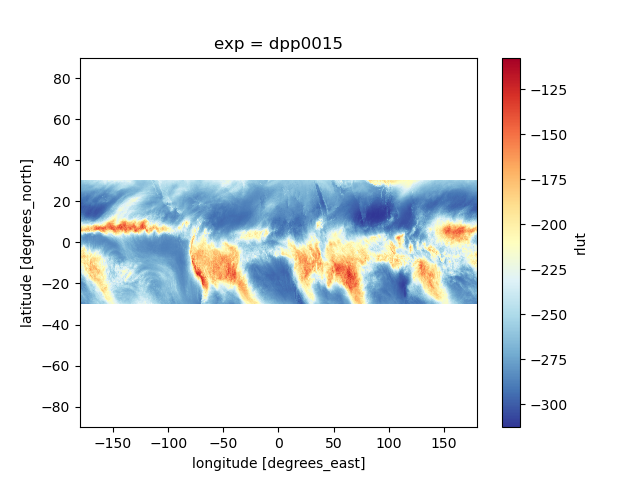

In [43]:
%matplotlib notebook 
# Use the notebook plotting backend from matplotlib
(-dset_remap['rlut']).sel({'exp': 'dpp0015'}).plot.imshow(cmap='RdYlBu_r')

These plots are not very nice but we can make them much nicer by using `cartopy` to draw maps. Xarray supports subplots and fiddeling with the colorbar. Let's create a nicer plot of net surface energy.

In [44]:
plot_data = dset_remap['net_surf_energy'].sel({'lat': slice(-30, 30)})
# Create a diff (exp1 - exp2)
plot_exps = list(plot_data.coords['exp'].values)
diff_data = plot_data.diff(dim='exp').assign_coords({'exp': [f'{plot_exps[1]} - {plot_exps[0]}']})

#Let's rename the dimension in diff_data
diff_data = diff_data.rename({'exp': 'diff'})

<IPython.core.display.Javascript object>


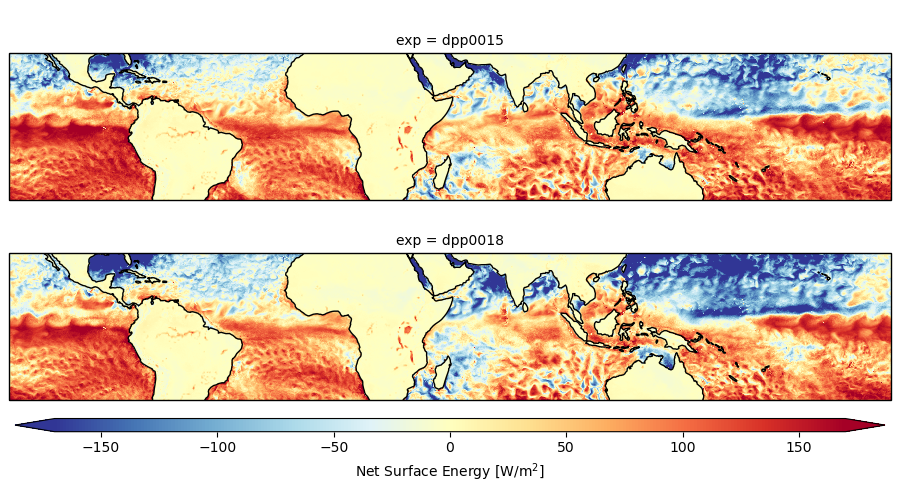

In [45]:
proj = ccrs.PlateCarree(central_longitude=50.) # Create ylindrical projections
plot = plot_data.plot(transform=ccrs.PlateCarree(), 
                      row='exp',
                      figsize=(9,5),
                      cmap='RdYlBu_r',
                      vmin=-170,
                      vmax=170,
                      subplot_kws={'projection': proj},
                      cbar_kwargs={'label': 'Net Surface Energy [W/m$^2$]',
                                   'extend': 'both', 
                                   'anchor': (0.5, -0.15),
                                   'fraction': 0.8,
                                   'aspect': 60,
                                   'orientation': 'horizontal'},
                                   
                     )
_ = [ax.coastlines() for ax in plot.axes.flat]
plot.fig.subplots_adjust(left=0.01, right=0.99, hspace=0, wspace=0, top=1, bottom=0.2)
plot

We could also plot the difference in a similar fashion:

<IPython.core.display.Javascript object>


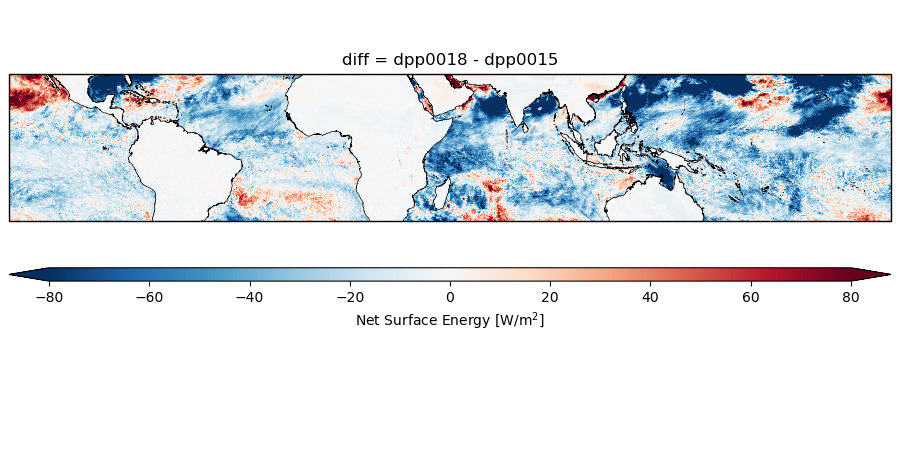

In [51]:
proj = ccrs.PlateCarree(central_longitude=50.) # Create ylindrical projections
fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(111, projection=proj)
plot = diff_data.plot(ax=ax,
                 transform=ccrs.PlateCarree(), # This is important
                 cmap='RdBu_r',
                 vmin=-80,
                 vmax=80,
                 cbar_kwargs={'label': 'Net Surface Energy [W/m$^2$]',
                              'extend': 'both', 
                              'aspect': 60,
                              'orientation': 'horizontal'},
                                   
                     )

You probably have noticed the ```%matplotlib notebook``` statements at the beginning of each cell where we plot. This is a so called *cell magic*, specifically it tells the jupyter that we are going to plot with a certain graphical user interface backend. Here we use an interface that allows us interactively change the plot. You can use the controls at the bottom to zoom and pad. You can also change the plot itself:

In [52]:
# Draw a thin high resolution coastline to the plot above
_ = ax.coastlines(resolution='10m', lw=0.5)
fig.subplots_adjust(left=0.01, right=0.99, hspace=0, wspace=0, top=1, bottom=0.3)

### 3.2 Plotting some time serie

Say we wanted to plot the time series for tropical *ocean* values only. This is easy to achieve we only need to multiply the `dataset` object with the sea mask and calculate a mean over the `ncells` dimension:

In [53]:
datasets['net_surf_energy']

<xarray.DataArray 'net_surf_energy' (time: 12, exp: 2, ncells: 20971520)>
dask.array<mul, shape=(12, 2, 20971520), dtype=float64, chunksize=(1, 1, 20971520), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-21 2020-01-22 ... 2020-02-01
  * exp      (exp) <U7 'dpp0015' 'dpp0018'
Dimensions without coordinates: ncells

In [54]:
# Apply the sea mask, and create averge
fldmean = (datasets * s_mask).mean(dim='ncells')

Again nothing has been calculated yet, let's trigger the computation in the background on the cluster:

In [55]:
fldmean = fldmean.persist()
progress(fldmean, notebook=True)

VBox()

The advantage is that the data is already loaded in the distributed memory. So any computations are fast. We can immediately plot the data: 

<IPython.core.display.Javascript object>


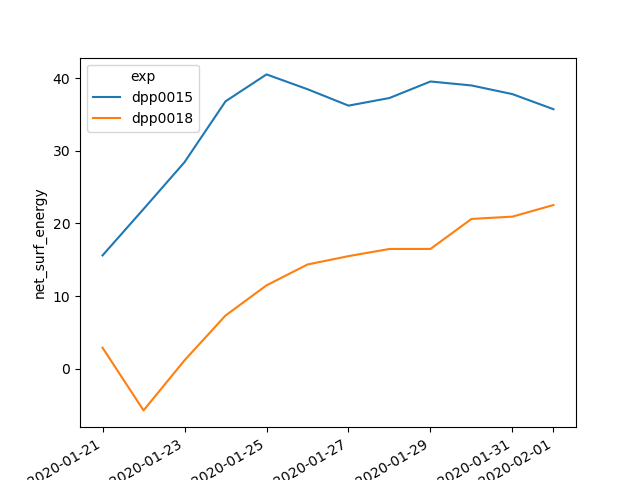

In [56]:
%matplotlib notebook
_ = fldmean['net_surf_energy'].plot.line(x='time')

Let's make this plot a little more pretty. The Seaborn library provides a nice interface for that:

In [57]:
# Tell seaborn to style the plots:
col_blind = sns.color_palette("colorblind", 10)
sns.set_style('ticks')
sns.set_palette(col_blind)
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})

Let's create a subplot with a time series and zonal averages of tropical ocean areas only. To do this we need a land-sea mask on a lat-lon grid which we have to create first.

In [58]:
# Create an xarray dataset from the s_mask array
mask_sea = xr.DataArray(s_mask, name='sea', dims=('ncells',))
mask_sea

<xarray.DataArray 'sea' (ncells: 20971520)>
dask.array<array, shape=(20971520,), dtype=float64, chunksize=(20971520,), chunktype=numpy.ndarray>
Dimensions without coordinates: ncells

In [59]:
# submit the remap job and get immediately the results
mask_sea_lonlat = dask_client.submit(remap,
                                     mask_sea, 
                                     grid_file, 
                                     griddes_file, 
                                     weightfile,
                                     scratch_dir, 
                                     attrs=global_attrs).result()
mask_sea_lonlat

<xarray.Dataset>
Dimensions:  (exp: 0, lat: 1800, lon: 3600)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * exp      (exp) float64 
Data variables:
    sea      (lat, lon) float64 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Jun 14 00:51:01 2020: cdo -O remap,/scratch/m/m300765/g...
    source:       git@gitlab.dkrz.de:icon/icon-aes.git@6b5726d38970a46b3ff1ac...
    institution:  Max Planck Institute for Meteorology
    title:        ICON simulation
    references:   see MPIM/DWD publications
    comment:      Sapphire Dyamond (k203123) on m11338 (Linux 2.6.32-754.14.2...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [60]:
zone_avg = (dset_remap*mask_sea_lonlat['sea'].data).sel({'lat':slice(-30, 30)}).mean(dim='lon')

<IPython.core.display.Javascript object>


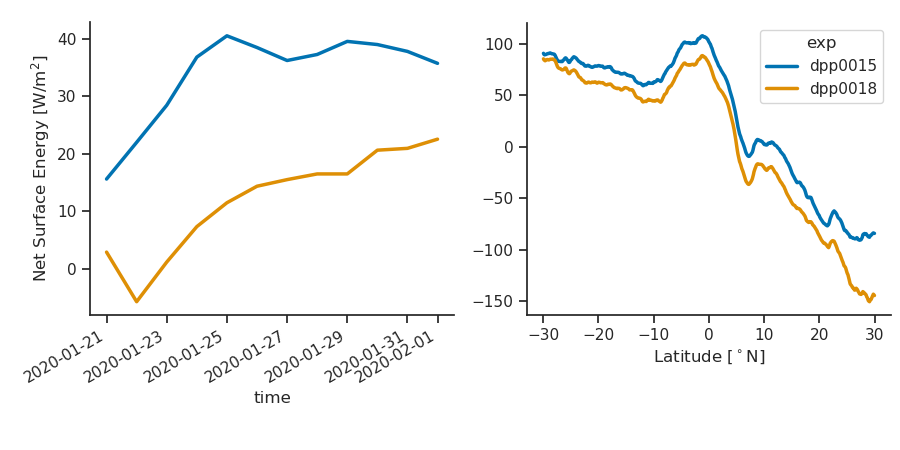

In [61]:
%matplotlib notebook
fig, axs = plt.subplots(1, 2,figsize=(9, 4.5), sharey=False)
_ = fldmean['net_surf_energy'].plot.line(x='time', ax=axs[0], add_legend=False)
axs[0].set_ylabel('Net Surface Energy [W/m$^2$]')
_ = zone_avg['net_surf_energy'].plot.line(x='lat', ax=axs[1])
axs[-1].set_ylabel('')
axs[-1].set_xlabel('Latitude [$^\circ$N]')
fig.subplots_adjust(left=0.1, right=0.99, wspace=0.2, top=.95, bottom=0.3)
sns.despine()

### 4.0 Working with 3D data

Working with 3D data can be a little more challenging because chances are high that the data wont fit into memory. So it is important to reduce the data as much as possible. But first lets open some 3D datasets and inspect them:

In [62]:
# Define the file pattern for qc, qi, pressure and qv
glob_pattern_3d = ('atm_3d_1_ml',  'atm_3d_3_ml', 'atm_3d_4_ml', 'atm_3d_5_ml')

In [63]:
datasets_3d = {exp: [] for exp in paths.keys()}
datasets_3d
# Open each file pattern for every experiment seperatly and merge the data into one dataset
for exp in datasets_3d.keys():
    for glob_pattern in glob_pattern_3d:
        datasets_3d[exp].append(
            xr.open_mfdataset(f'{paths[exp] / exp}*{glob_pattern}*.nc',
                              parallel=True,
                              combine='by_coords',
                             chunks={'time': 1, 'height': 5} # This is important
                             ).sel({'time': slice('2020-01-21T00:00:00', '2020-01-31T18:00:00')})
        )
    # Merge the datasets (each for one variable) and select the time where both experiments have data
    datasets_3d[exp] = xr.merge(datasets_3d[exp])

Note the chunks parameter. This tells xarray to try split up the data into chunks of 1 in time and 5 in height. When dealing with large datasets like here the chunk size is important because each data chunk will be distributed across the cluster memory. If the chunk size is to big (to little chunks) the worker nodes might run out of memory if on the other hand the there are to many chunks (to small chunk size) the cluster might die from communication overhead. In this case we have 77 levels so a chunk size of 5 could be a good choice. Read more about chunking on https://docs.dask.org/en/latest/array-chunks.html

In [64]:
# Check the total size of the datasets
filesize(np.sum([dset.nbytes for dset in datasets_3d.values()]))

'2T'

We have 'only' 2.15 TB of memory available so the will barely fit into memory. Since we're just interested in tropical profiles we can reduce the number significantly averaging. The problem is during the data reduction process (averaging) much more memory will we consumed hence more memory. Let's do the average operation one experiment and 4 days at a time. This will take a while but we wont choke the cluster. 

In [66]:
for exp, data in datasets_3d.items():
    # Split the data by day:
    days, daily_data = zip(*data.resample({'time': '4d'})) # Split data set into chunks of 4 days
    print(f'{exp}: Averaging chunk 1/{len(days)}', flush=True)
    dset = daily_data[0].mean(dim='time').persist() # Push the 1st day to the cluster, wait unitl finished
    progress(dset, notebook=False)
    print('\b')
    wait(dset)
    for nn, data in enumerate(daily_data[1:]):
        print(f'{exp}: Averaging chunk {nn+2}/{len(days)}', flush=True)
        tmp_data = data.mean(dim='time').persist()
        wait(tmp_data)
        dset += tmp_data
        del tmp_data
    datasets_3d[exp] = (dset / len(days)).persist()
    del dset # Delete unsused arrays (just in case)
    wait(datasets_3d[exp])

dpp0015: Averaging chunk 1/3
[########################################] | 100% Completed |  5min 36.9s
dpp0015: Averaging chunk 2/3
[########################################] | 100% Completed |  0.5s
dpp0015: Averaging chunk 3/3
[########################################] | 100% Completed |  0.3s
dpp0018: Averaging chunk 1/3
[########################################] | 100% Completed |  1min 58.4s
dpp0018: Averaging chunk 2/3
[########################################] | 100% Completed |  0.4s
dpp0018: Averaging chunk 3/3
[########################################] | 100% Completed |  0.3s


This operation will take some time, so grab another coffee or tea and hope the cluster won't run out of memory.

Experiment dpp0016 has a file that describes the z coordinates lets load it for using it as the new height coordinate later:

In [190]:
z_file = Path('/work/mh0287/k203123/GIT/icon-aes-dyw_albW/experiments/dpp0016/dpp0016_atm_vgrid_ml.nc')
z_data = xr.open_mfdataset([z_file], combine='by_coords', chunks={'height_2': 5, 'height': 5})['zg']
z_data.data = (z_data.data - z_data.isel({'height_2': -1}).data + 25)
z_data = xr.Dataset(data_vars={'zg': z_data}).rename({'height_2':'height'}).persist()
_ = wait(z_data) # Wait until loaded

In [191]:
height = np.round(z_data['zg'].isel({'ncells': 0}).values.round(0)[30:] / 10) * 10 
for exp in datasets_3d.keys():
    datasets_3d[exp]['zg'] = z_data['zg']

In [176]:
datasets_3d

<xarray.Dataset>
Dimensions:  (exp: 2, height: 90, ncells: 20971520)
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(20971520,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(20971520,), meta=np.ndarray>
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 86.0 87.0 88.0 89.0 90.0
  * exp      (exp) <U7 'dpp0015' 'dpp0018'
Dimensions without coordinates: ncells
Data variables:
    pfull    (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    ta       (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    wap      (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    cl       (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    hus      (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    clw      (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>
    cli      (exp, height, ncells) float32 dask.array<chunksize=(1, 5, 20971520), meta=np.ndarray>

In [80]:
# Merge the dataset together
datasets_3d = xr.concat([dset for dset in datasets_3d.values()], dim='exp').assign_coords({'exp': dpp_runs})
datasets_3d = datasets_3d.drop_vars({'height_bnds'}) # Get rid of height_bnds

In [194]:
shape = datasets_3d.coords['exp'].shape[0], len(height), datasets_3d.coords['ncells'].shape[0]
shape

(2, 60, 20971520)

Now we will use the stratify library to interpolate the data to constant z height.

In [141]:
import stratify

In [199]:
new_data = {}
for varn in datasets_3d.data_vars:
    # Do the interpolation on the cluster with dask.delayed
    tmp = dask.delayed(stratify.interpolate)(height, z_data['zg'].data, datasets_3d[varn].data, axis=1)
    # Create an xarray data array from the delayed object
    new_data[varn] = xr.DataArray(dask.array.from_delayed(tmp, shape=shape, dtype=np.float32),
                                  name=varn,
                                  dims=('exp', 'Z', 'ncells'),
                                  coords={'exp':datasets_3d.coords['exp'], 
                                          'Z': height}).persist()
progress(new_data, notebook=True)

VBox()

In [203]:
new_data = xr.Dataset(data_vars=new_data).persist()

Let's create some cloud-water/ice and relative humidity profiles for tropical ocean and land here we can also apply the masks.

In [205]:
data  = {}
data['Land'] = (new_data * mask_tr * l_mask).mean(dim='ncells').persist()
wait(data) # Wait until done, not to choke clusters memory
data['Ocean'] = (new_data * mask_tr * s_mask).mean(dim='ncells').persist()
wait(data)
data['Land&Ocean'] = (new_data * mask_tr).mean(dim='ncells').persist()
progress(data, notebook=True)

VBox()

In [206]:
# Let's lumb the datasets along a new dimension together
data = xr.concat([dset for dset in data.values()], dim='surf').assign_coords({'surf':list(data.keys())})
data['Z'].attrs = {'standard_name': 'Z', 'units': 'km'}
data = data.load() # Load the data into local memory

We want calculate a relative humidity profile. The `metpy` packages offers a lot of calculation routines. You can check what type of calculation is available on their website https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html . Metpy is handy as it also takes care about units:

In [207]:
# Calculate relative humidity
rh = metcalc.relative_humidity_from_specific_humidity(
    data['hus'].data * metunits('kg/kg'),
    data['ta'].data * metunits('K'),
    data['pfull'].data * metunits('Pa')
).magnitude

In [225]:
data['rh'] = xr.DataArray(rh*100.,
                          name='rh',
                          coords=data['cl'].coords,
                          dims=data['cl'].dims,
                          attrs={'standard_name': 'RH',
                                 'units': '%'})
data['Z'].data = data['Z'].data / 1000.

<IPython.core.display.Javascript object>


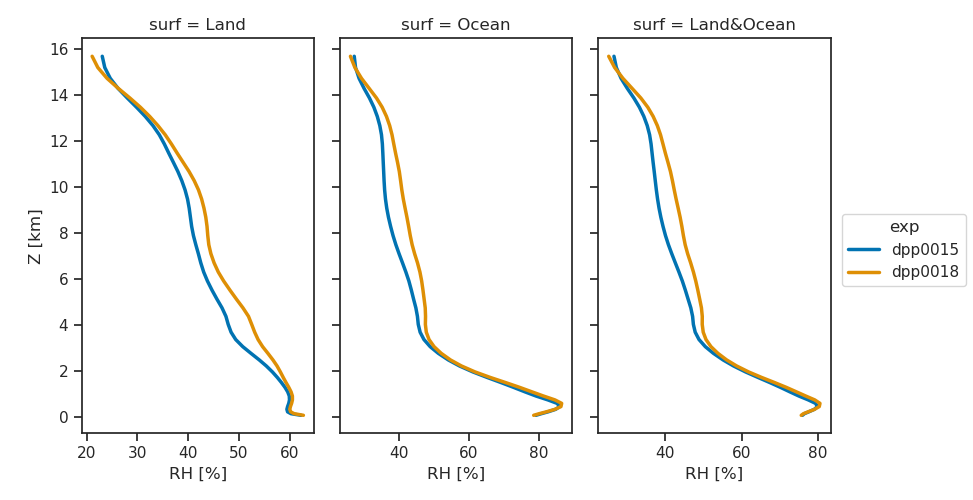

In [228]:
%matplotlib notebook
plot = data['rh'].isel({'Z':slice(10, 60)}).plot.line(y='Z', 
                                                           col='surf', 
                                                           figsize=(8.5,5),
                                                           sharex=False)

<IPython.core.display.Javascript object>


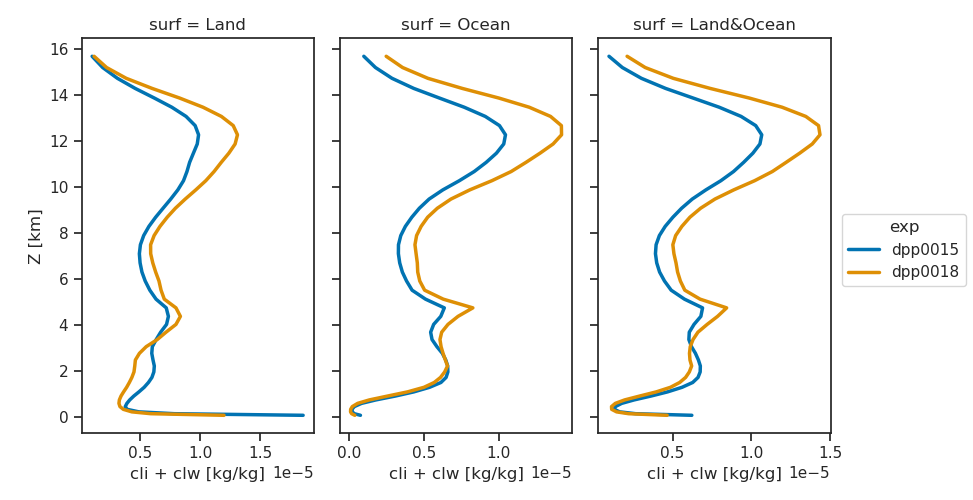

In [229]:
%matplotlib notebook
clx = data['clw'] + data['cli']
clx.attrs = {'standard_name': 'cli + clw' , 'units': 'kg/kg'}
plot = clx.isel({'Z':slice(10, 60)}).plot.line(y='Z', col='surf', figsize=(8.5,5), sharex=False)

### Conclusion

This notebook presented some techniques to analyze dyamond datasets in python. We basically utilized `xarray` a very powerful data processing library to work with multi dimensional data. `xarray` builds up on `dask` a library that makes distributed data processing easy. 

Specifically we created a cluster of 10 workers with 420 cpu cores and nearly 2.5 TB of memory. This cluster was used to process the dyamond data across the workers. This setup allowed us to use the native grid with its high resolutions as much as possible. Only when plotting maps we had to involve cdo for remapping.

Altogether we have actively have utilized more than 400 GB of memory with peak usages of nearly 1 TB this would have never been possible with a single computer.

There are several pitfalls when it comes to distributed data processing. First it is essential to understand that computations are collected as much as possible rather than triggered immediately. This has the advantage that task streams can be optimized - this technique is called map reduce. Computations should be triggered only at the last moment. Another crucial part is data chunking this is especially true for 3D data. Choosing the right chunk size can be challenging at times but is important in order to keep the clusters memory intact.

The reader might have noticed that reading the data and especially plotting can be convoluted. Hence the next notebook will demonstrate some functionalities that have been added to this repository to make data processing and plotting a little more easy.